Creating training, validation and test sets

In [ ]:
import math
import torchvision.models as models
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import kagglehub
import zipfile 
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')

device = torch.device("cuda:0")                                 #We use the GPU for training 

transform = transforms.Compose([                              #transform function 
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),              #Since the images are grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

''' 
Now we define the training, validation and test sets
'''
training_dir = './chest_xray/chest_xray/train' 
training_set = datasets.ImageFolder(root=training_dir, transform=transform)

validation_dir = './chest_xray/chest_xray/val'
validation_set = datasets.ImageFolder(root=validation_dir, transform=transform)

test_dir = './chest_xray/chest_xray/test'
test_set = datasets.ImageFolder(root=test_dir, transform=transform)

'''
Now we define the training loaders and validation loaders
'''

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

classes = training_set.classes
print("Classes in the dataset:", classes)  

c:\Users\yanni\OneDrive\Bureaublad\RadboudJaar3\Thesis\project files\thesisenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classes in the dataset: ['NORMAL', 'PNEUMONIA']


Evaluating results


PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  NORMAL  NORMAL  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  NORMAL  NORMAL  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA  NORMAL  PNEUMONIA  NORMAL  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA  PNEUMONIA  PNEUMONIA  PNEUMONIA  NORMAL  PNEUMONIA


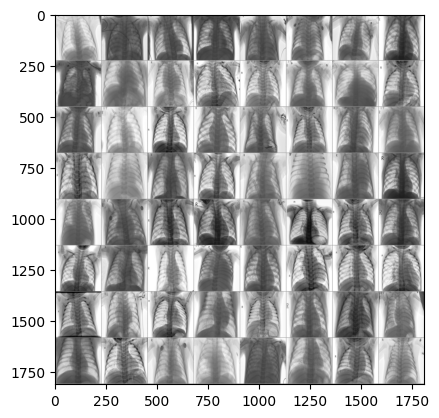

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a batch of images and labels
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

# Use the correct classes from the ImageFolder dataset
print('  '.join([training_set.classes[label.item()] for label in labels]))  # Accessing the class name properly


Resnet-152 construction & initialisation

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224,224
NUM_CLASSES = 2
BATCH_SIZE = 32
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = True


In [4]:
##########################
### MODEL copied from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet152-celeba.ipynb
##########################

import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)                origineel
        self.avgpool = nn.AdaptiveMaxPool2d((1,1))                          #deepseek suggestie 
        #self.fc = nn.Linear(2048 * block.expansion, num_classes)           origneel 
        self.fc = nn.Linear(2048, num_classes)                              #deepseek suggestie

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = torch.flatten(x,1) #weghalen

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 36, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

model = resnet152(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  


Training 

In [5]:



def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(training_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        print(features.shape)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(training_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, training_loader, device=DEVICE),
              compute_accuracy(model, validation_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

torch.Size([64, 1, 224, 224])
Epoch: 001/040 | Batch 0000/0082 | Cost: 1.9473
torch.Size([64, 1, 224, 224])


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.30 GiB is allocated by PyTorch, and 325.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Evaluation

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))


for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

model.eval()
logits, probas = model(features.to(DEVICE)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))